<a href="https://colab.research.google.com/github/Muaz-Hossain/shape-detector-opencv/blob/main/ShapeDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive, files
import os

In [ ]:
# uplode video
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]
print(f"Uploaded video: {video_filename}")

Saving VID20251221164028.mp4 to VID20251221164028.mp4
Uploaded video: VID20251221164028.mp4


In [ ]:
class ShapeDetector:
  def __init__(self):
    self.color = {
        'triangle':(255,0,0),
        'square':(0,255,0),
        'circle':(0,165,255),
        'rectangle':(0,255,255),
    }

  def classify_shape(self,cnt):
    #Approximate the contour
    perimeter = cv2.arcLength(cnt,True)
    epsilon = 0.04 * perimeter
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    sides = len(approx)

    #get bounding rectangle
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h) if h > 0 else 0

    #classily

    if sides == 3:
      return 'triangle', approx
    elif sides == 4:
      if 0.95 < aspect_ratio < 1.1:
        return 'square', approx
      else:
        return 'rectangle', approx
    elif sides > 6:
      #check circularity
      area = cv2.contourArea(cnt)
      (_,_),radius = cv2.minEnclosingCircle(cnt)
      circle_area = np.pi * radius ** 2
      circularity = area / circle_area if circle_area > 0 else 0
      if circularity > 0.85:
        return 'circle', approx
      else:
        return 'oval', approx
    return f"{sides}", approx

  def process_frame(self,frame):
    #make copy for dowing
    output = frame.copy()

    #preprocessing
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray,(5,5),0)
    edged = cv2.Canny(blurred,50,150)

    #find contour
    contours, _ = cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    detected_shapes = []
    for cnt in contours:
      # Ensure contour has enough points to be valid before processing
      if len(cnt) < 3:
        continue
        area = cv2.contourArea(cnt)

      #filter by sizes
        if 500 < area < 10000:
          shape_name, approx = self.classify_shape(cnt)
        #get bounding box
          x,y,w,h = cv2.boundingRect(approx)
        #get color
          color = self.color.get(shape_name, (0,0,255))
        #draw contours
          cv2.drawContours(output,[cnt],-1,color,2)
        #draw bounding box
          cv2.rectangle(output,(x,y),(x+w,y+h),color,2)
        #add label
          label = f"shape: {shape_name}"
          cv2.putText(output,label,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        #add area
          cv2.putText(output,f"area: {int(area)}",(x,y+h+20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
          detected_shapes.append({
              'name':shape_name,
              'area':area,
              'bbox':(x,y,w,h)
          })
      return output, detected_shapes
    return output, detected_shapes
print("Shape detected class created")

Shape detected class created


In [ ]:
def Video_process(input_path,output_path='output_video.mp4'):
  cap = cv2.VideoCapture(input_path)
  if not cap.isOpened():
    print("Error opening video file")
    return None

  #get video proparties
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  print(f"video info:")
  print(f"fps: {fps}")
  print(f" Resolution: {width}x{height}")
  print(f"Total frames: {total_frames/fps:.1f} secound")

  #create video writer
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(output_path,fourcc,fps,(width,height))

  #Initialize detector
  detector = ShapeDetector()

  #process each frame
  frame_count =0
  shape_statistics = {}
  print('processing frames...')
  while True:
    ret, frame = cap.read()
    if not ret:
      break
    frame_count +=1
    #show frame every 50 frames
    if frame_count % 50 == 0:
      print(f"Processing frame {frame_count}/{total_frames} frame")

    #process frame
    processed_frame, shapes = detector.process_frame(frame)

    #update statistics
    for shape in shapes:
      name = shape['name']
      if name in shape_statistics: # Corrected from 'shape' to 'name'
        shape_statistics[name] += 1
      else:
        shape_statistics[name] = 1
    #write frame
    out.write(processed_frame)

  #cleanup
  cap.release()
  out.release()
  print('processing complete')
  print(f"output saved as :{output_path}")
  print("shape detected")

  for shape, count in sorted(shape_statistics.items()):
    print(f"{shape}: {count}")
  return output_path
#process uploaded video
output_video = Video_process(video_filename)

video info:
fps: 29
 Resolution: 1080x1920
Total frames: 10.4 secound
processing frames...
Processing frame 50/303 frame
Processing frame 100/303 frame
Processing frame 150/303 frame
Processing frame 200/303 frame
Processing frame 250/303 frame
Processing frame 300/303 frame
processing complete
output saved as :output_video.mp4
shape detected


previewing3 frames from output_video.mp4
1 (original position: 0)


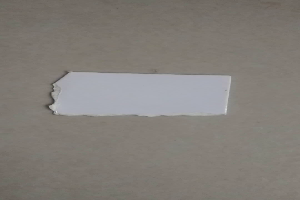

2 (original position: 151)


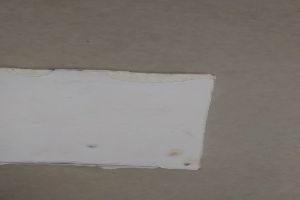

3 (original position: 302)


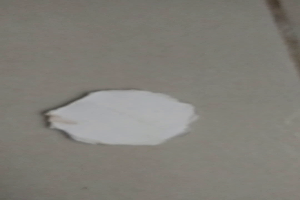

In [ ]:
# show simple frame from process video
def preview_video(video_path,frame_number=3):
  cap = cv2.VideoCapture(video_path)
  #get totall frame
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  #select frame
  frame_indices = [
      0,
      total_frames //2,
      total_frames -1
  ]
  print(f"previewing{frame_number} frames from {video_path}")
  for i, frame_idx in enumerate(frame_indices[:frame_number]):
    cap.set(cv2.CAP_PROP_POS_FRAMES,frame_idx)
    ret, frame = cap.read()
    if ret:
      frame = cv2.resize(frame,(300,200))
      print(f"{i+1} (original position: {frame_idx})")
      cv2_imshow(frame)
  cap.release()
if output_video:
  preview_video(output_video)